In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))


import matplotlib.pyplot as plt
import my_utils as utils
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer

from utils.collator import SequenceGenerationCollator
from utils.model import MmLlamaConcat, MmLlamaConfig
from utils.processor import MmLlamaProcessor

BASE_PATH = os.path.join("results", "early_concat")
INSTRUCTERC_BASE_PATH = os.path.join("results", "instructerc")

# Early concatenation

In diesem Abschnitt werden die erzielten Ergebnisse und das Early-Concatenation Modell weitergehend untersucht, um folgenden Forschungsfragen zu beantworten:
- Wie ist die performance auf IEMOCAP und MELD
- Gibt es Änderungen in der Klassifizierung im Vergleich zum normalen InstructERC
  - Wenn ja, welche?
- Was wird durch die Akustik erkannt?
  - Was wird nur durch Akustik erkannt?
  - Gibt es Verbesserungen in bestimmten Emotionen
- Kann das Modell das volle Potenzial aus beiden Modalitäten ausnutzen?
- Nutzt das Modell die neuen Feature?
- Hat das Vortraining einen Einfluss auf die Effektivität des Modells

## IEMOCAP



In [2]:
DATASET = "IEMOCAP"


def get_result_dataframe(dataset: str) -> pd.DataFrame:
    normal_path = os.path.join(BASE_PATH, dataset, "preds_test_normal.json")
    audio_path = os.path.join(BASE_PATH, dataset, "preds_test_audio_only.json")

    normal_df = utils.build_result_dataframe(normal_path)
    audio_df = utils.build_result_dataframe(audio_path)
    ierc_df = utils.get_instructerc_results(INSTRUCTERC_BASE_PATH, dataset)

    assert len(normal_df) == len(audio_df) == len(ierc_df)

    results = utils.merge_result_dataframes([normal_df, audio_df, ierc_df], ["normal", "audio", "ierc"])
    results = utils.extract_dialogue_information(results)

    return results


df_iemocap = get_result_dataframe(DATASET)
df_iemocap.head(3)

,input,output,target,input_audio,output_audio,input_ierc,output_ierc,utterance,dialogue_length,utterence_length
index,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,neutral,Now you are expert of sentiment and emotional ...,neutral,Now you are expert of sentiment and emotional ...,frustrated,"Hi, I need an ID.",1,5
1,Now you are expert of sentiment and emotional ...,neutral,neutral,Now you are expert of sentiment and emotional ...,excited,Now you are expert of sentiment and emotional ...,neutral,"ahh Yeah, this is the wrong line. I'm sorry. ...",2,26
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,Now you are expert of sentiment and emotional ...,frustrated,Now you are expert of sentiment and emotional ...,frustrated,"Okay, I'm sorry, but I just stood in this line...",3,21


### Performance

Dafür wird der gewichtete F1 Score berechnet:
\begin{equation}
    F1 = 2\cdot\frac{precision\cdot recall}{precision + recall}
\end{equation}
Dieser wird für jedes Label berechnet und durch die Anzahl der label normalisiert.
Dadurch bekommt jedes Label, unabhängig von der Anzah, die selbe Gewichtung im Gesamtergebnis.

In [3]:
from sklearn.metrics import f1_score


labels = df_iemocap["target"].value_counts().index.to_list()

concat_model_f1 = f1_score(df_iemocap["target"], df_iemocap["output"], average="weighted", labels=labels)
audio_only_f1 = f1_score(df_iemocap["target"], df_iemocap["output_audio"], average="weighted", labels=labels)
text_only_f1 = f1_score(df_iemocap["target"], df_iemocap["output_ierc"], average="weighted", labels=labels)

print(f"F1-Score des Concatenation Modells: {concat_model_f1:.3f}")
print(f"F1-Score mit nur audio input: {audio_only_f1:.3f}")
print(f"F1-Score des Basismodells: {text_only_f1:.3f}")

F1-Score des Concatenation Modells: 0.699
F1-Score mit nur audio input: 0.442
F1-Score des Basismodells: 0.696


Betrachten wir uns nun die Confusion-Matrix des Concatination Modells.
In Klammern ist der prozentuale Anteil der Zeile angegeben. Daran orientiert sich ebenfalls auch die Farbgebung.

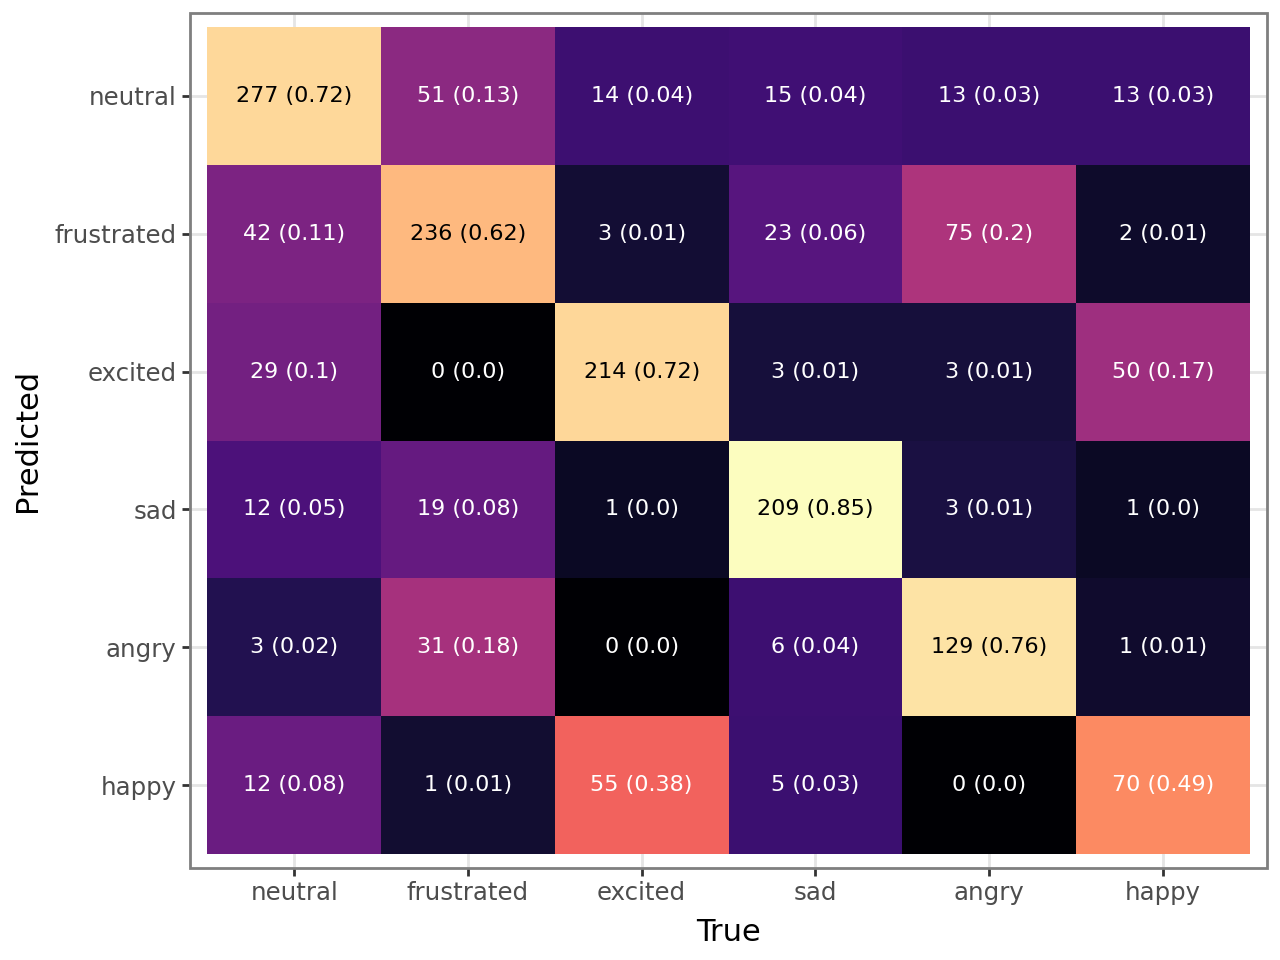

In [4]:
utils.print_confusion_matrix(df_iemocap, target_labels=labels[::-1], output_column="output")

Auffälligkeiten:
Es können entgegengesetzte Emotionen definiert werden. Die eine Klasse bilden die positiven Emotionen "happy" und "excited, die andere negative Emotionen "sad", "angry" und "frustrated".
Zwischen diesen beiden Gruppen gibt es so gut wie keine Verwechselungen, wie die Confusion-Matrix, mit einteilung in positiv und negativ, zeigt.

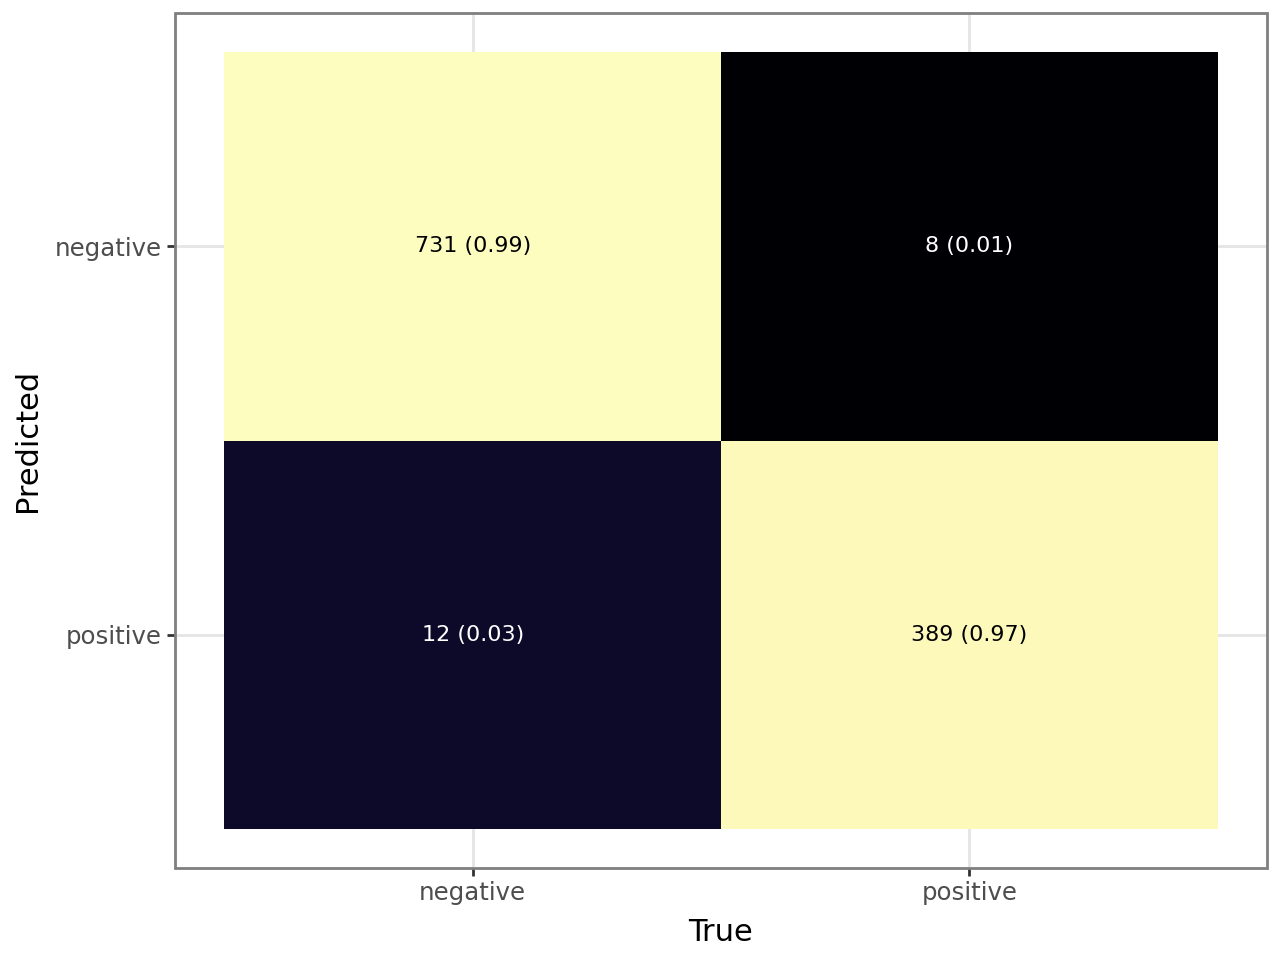

In [5]:
from functools import partial


iemocap_positive_emotions = ["happy", "excited"]
iemocap_negative_emotions = ["angry", "sad", "frustrated"]


iemocap_classify_sentiment = partial(utils.classify_sentiment, positive=iemocap_positive_emotions, negative=iemocap_negative_emotions)

df_iemocap["emotion_sentiment"] = df_iemocap["target"].apply(iemocap_classify_sentiment)
df_iemocap["emotion_sentiment_prediction"] = df_iemocap["output"].apply(iemocap_classify_sentiment)


utils.print_confusion_matrix(df_iemocap, target_labels=["positive", "negative"], output_column="emotion_sentiment_prediction", target_column="emotion_sentiment")

Insgesammt werden nur 20 von 1110 Beispiele, also $\sim$ 1,18% zwischen den Gruppen falsch zugeordnet.

Anders sieht es bei der Intra-Klassenverwechselung aus:

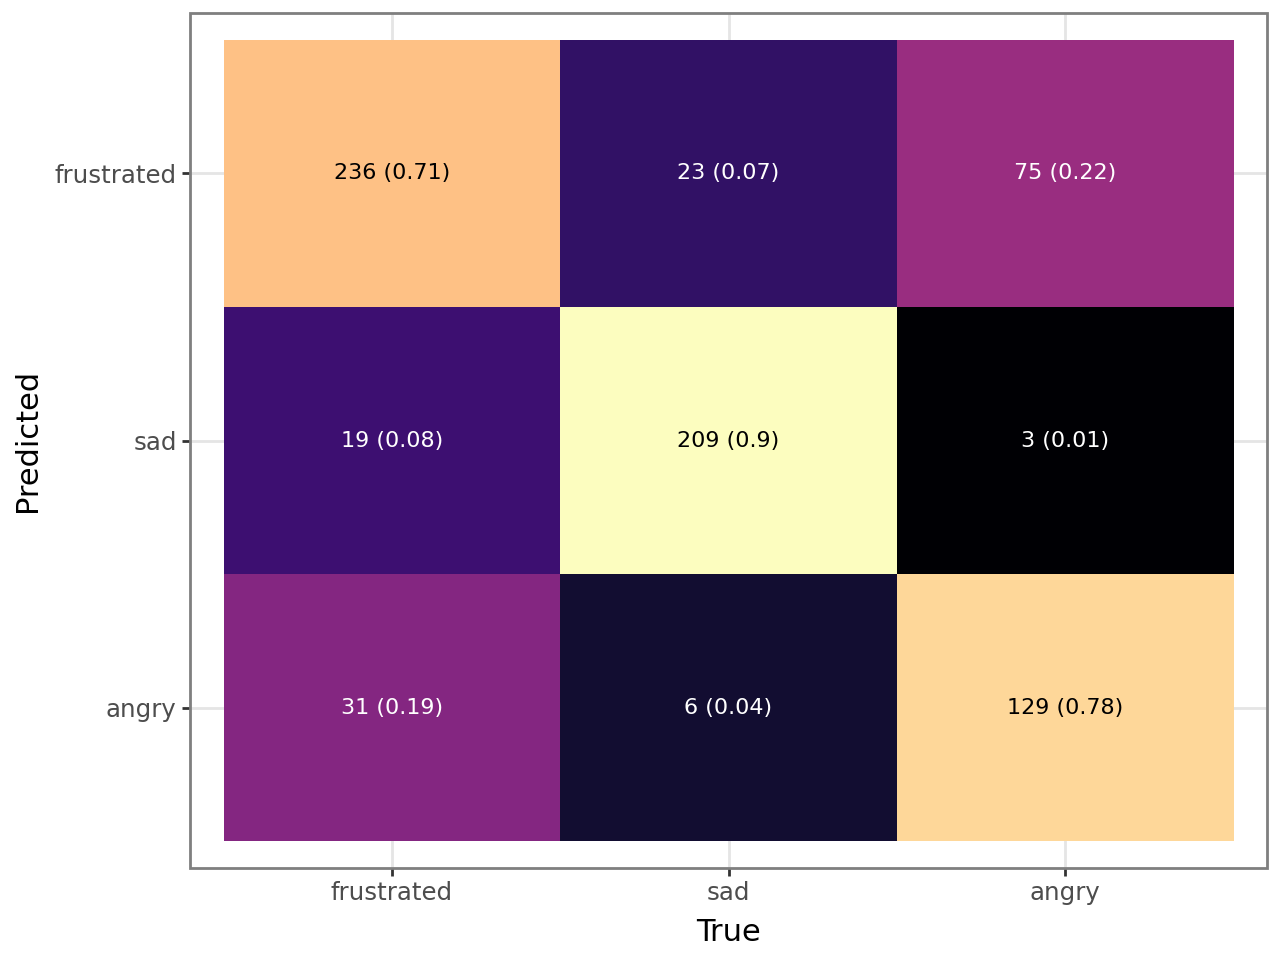

In [8]:
utils.print_confusion_matrix(
    df_iemocap,
    target_labels=iemocap_negative_emotions,
    output_column="output",
    target_column="target",
)

In den negativen Emotionen kommt es insbesondere bei Wut und Frustration zu Verwechselungen.
Trauer kann sehr gut von Wut auseinandergehalten werden, hier kommt es kaum zu Verwechselungen.

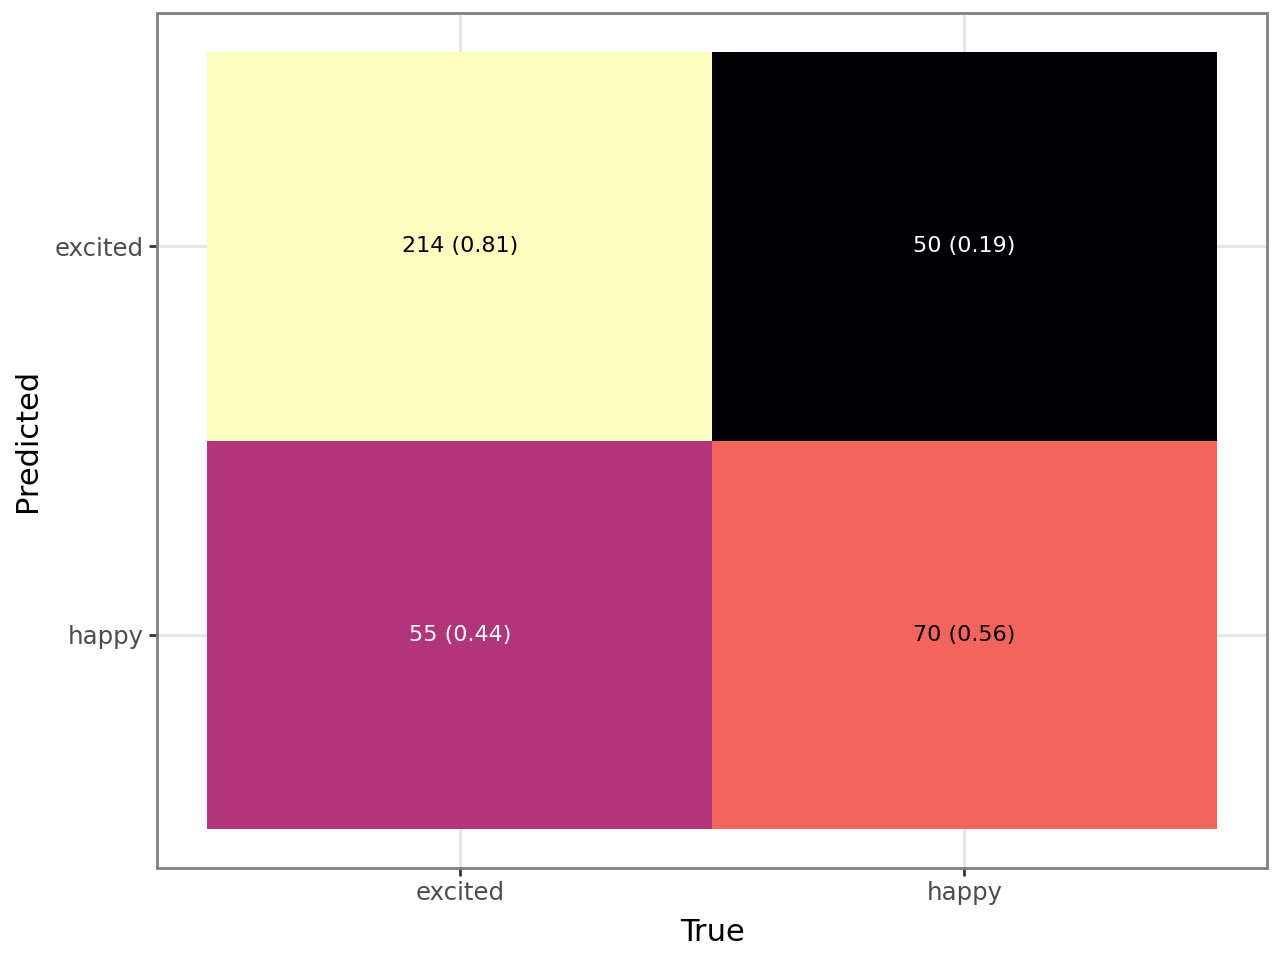

In [9]:
utils.print_confusion_matrix(
    df_iemocap,
    target_labels=iemocap_positive_emotions,
    output_column="output",
    target_column="target",
)

In der positiven Gruppe kommt es zu ähnlich häufigen Verwechselungen zwischen Aufgeregt udn Glücklich.
Zu beachten ist aber, dass "Glücklich" mit 143 Beispielen die am wenigsten vertretene Emotion im Datensatz ist, weshalb hier fast die Hälfte der aller Vorhersagen in die zweitmeist vertretene Klasse "Aufgeregt" geordnet werden.

Weiter wird untersucht, worin die Veränderungen bestehen.
Geguckt wird, wieviele Beispiele jetzt nicht mehr erkannt werden und wie viele jetzt erkannt werden.

In [28]:
both_correct_but_not_text = df_iemocap[(df_iemocap["output"] == df_iemocap["target"]) & (df_iemocap["output_ierc"] != df_iemocap["target"])]
text_correct_but_not_both = df_iemocap[(df_iemocap["output_ierc"] == df_iemocap["target"]) & (df_iemocap["output"] != df_iemocap["target"])]


print(f"Nach dem Hinzufügen der Akustik können {len(both_correct_but_not_text)} Beispiele erkannt werden, die vorher nicht erkannt wurden")
print(f"Nach dem Hinzufügen der Akustik können {len(text_correct_but_not_both)} Beispiele nicht mehr richtig erkannt werden")

Nach dem Hinzufügen der Akustik können 172 Beispiele erkannt werden, die vorher nicht erkannt wurden
Nach dem Hinzufügen der Akustik können 165 Beispiele nicht mehr richtig erkannt werden


Es zeigt sich, dass das Modell fast so viele Beispiele nicht mehr richtig erkennt, wie es jetzt neu erkennt.
Dies erklärt den nur leicht gestiegenen F1-Score.

Als nächstes wird geguckt, ob es Auffälligkeiten in den Emotionen gibt, also ob jetzt bestimmte Emotionen besser erkannt werden als vorher.
Dafür wird einmal der F1-Score für jede Emotion berechnet und die Veränderung  

In [27]:
text_only_correct = df_iemocap[(df_iemocap["output_ierc"] == df_iemocap["target"]) & (df_iemocap["output_audio"] != df_iemocap["target"])]
audio_only_correct = df_iemocap[(df_iemocap["output_ierc"] != df_iemocap["target"]) & (df_iemocap["output_audio"] == df_iemocap["target"])]
both_only_correct = df_iemocap[(df_iemocap["output"] == df_iemocap["target"]) & (df_iemocap["output_audio"] != df_iemocap["target"]) & (df_iemocap["output_ierc"] != df_iemocap["target"])]
text_correct_but_not_both = df_iemocap[(df_iemocap["output_ierc"] == df_iemocap["target"]) & (df_iemocap["output"] != df_iemocap["target"])]
audio_correct_but_not_both = df_iemocap[(df_iemocap["output_audio"] == df_iemocap["target"]) & (df_iemocap["output"] != df_iemocap["target"])]
text_correct_but_not_audio_and_both = df_iemocap[(df_iemocap["output_ierc"] == df_iemocap["target"]) & (df_iemocap["output_audio"] != df_iemocap["target"]) & (df_iemocap["output"] != df_iemocap["target"])]
audio_correct_but_not_text_and_both = df_iemocap[(df_iemocap["output_ierc"] != df_iemocap["target"]) & (df_iemocap["output_audio"] == df_iemocap["target"]) & (df_iemocap["output"] != df_iemocap["target"])]

print(f"es konnten {len(text_only_correct)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only")
print(f"es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only")
print(f"es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input")
print(f"es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input")
print(f"es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input")
print(f"es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input")

es konnten 566 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only
es konnten 172 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only
es konnten 96 Datenpunkte nur durch gemeinsamen Input erkannt werden
es konnten 165 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input
es konnten 160 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input
es konnten 101 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input
es konnten 96 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input


Weiter untersuchen: 
- 

## Attention-Weights

Um zu untersuchen, ob das training effektiv und das Modell die zusätzlichen feature tatsächlich verwendet, untersuchen wir die Attention-Weight Matrix.
Diese gibt aufschluss darüber, worauf sich das Modell konzentriert.
Zur erinnerung, die Attention-Matrix ist eine $T_x \times T_x$ Matrix, wobei $T_x$ für die Länge der Eingabesequenz steht.
Diese ist besitzt nur im unteren linken Dreieck $\{A_{i,j} \mid i \ge j\}$ Werte, während alle anderen 0 betragen.
Eine Begründung dafür steht in Abschnitt (ref...).
Jede Zeile enthält das Attenntion-Query Ergebnis eines Query-Vektors, während die Spalten die Ergebnisse der Keys representiert.
Zu interpretieren ist also eine Zeile, dass sich aus der neue Kontext-Vektor für den Token zu prozentualen Anteilen zusammensetzt, wie diese in der Zeile stehen.
Währenddessen zeigt jede Zeile, wie stark ein gegebener Token zum nächsten Zustand beigetragen hat.
Befinden sich in einer Spalte nur niedrige Werte, hat dieser Token wenig zum Ergebnisausgang beigetragen.

Wenn man also überprüfen möchte, ob das Netz die akustischen Feature tatsächlich verwendet, sollte es keine besonderen Auffälligkeiten oder erhöhte Werte in den Spalten der Audio-Token geben.

In [9]:
LANGUAGE_MODEL = os.path.abspath("../../models/language/LLaMA2-base")
LORA_ADAPTER = os.path.abspath("../../models/language/adapter/iemocap/LLaMA2-base")
ACOUSTIC_MODEL = os.path.abspath(
    "../../models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
)
DS_TRAIN_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_DEV_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_TEST_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
STAGE1_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1"
)
STAGE2_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1"
)

In [12]:
def get_attention_weights(
    model: MmLlamaConcat,
    dataset_path: str,
    processor: MmLlamaProcessor,
    layer_idx=0,
    sample_index=0,
):
    sample = utils.get_sample(
        dataset_path,
        processor,
        [sample_index],
        collator_type=SequenceGenerationCollator,
        dataset_kwargs={"task": "normal", "audio_placement": "target"},
    )

    llama = model.llama
    att1 = llama.get_submodule(f"model.layers.{layer_idx}.self_attn")

    attention_weights = None

    def attention_hook(module, input, output):
        nonlocal attention_weights
        attention_weights = output[1]

    att_handle = att1.register_forward_hook(attention_hook)

    def prepate_nested_batch(batch: dict[dict[torch.Tensor]]):
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda"

        text = {k: v.to(device) for k, v in batch["text"].items()}
        acoustic = {k: v.half().to(device) for k, v in batch["acoustic"].items()}

        return {**text, **acoustic}

    with torch.no_grad():
        _ = model(**prepate_nested_batch(sample))

    att_handle.remove()
    return attention_weights[0].cpu().numpy()


def print_attention_weight_matrix(
    attention_weights: np.ndarray,
    sample,
    config: MmLlamaConfig,
    tokenizer: AutoTokenizer,
):
    head_norm = attention_weights.mean(axis=0)
    head_norm = np.apply_along_axis(lambda x: x / np.max(x), 1, head_norm)

    audio_token_id = config.audio_token_id

    token_ids = sample["text"]["input_ids"][0].cpu().numpy()
    audio_loc = np.where(token_ids == audio_token_id)[0][0]
    token_ids = np.concatenate(
        (token_ids[:audio_loc], [audio_token_id] * 10, token_ids[audio_loc:])
    )
    token_strings = np.array(tokenizer.convert_ids_to_tokens(token_ids))
    # token_strings[token_ids == 0] = ""

    mean_attention = np.mean(head_norm, axis=0, where=head_norm != 0)
    # print(mean_attention)
    top_token_ids_idx = np.argsort(mean_attention)[::-1][:25]
    # print(top_token_ids_idx)
    # last_token_ids_idx = np.argsort(mean_attention)[:10]
    audio_loc_idx = np.where(token_ids == audio_token_id)[0]
    selected_tokens = np.unique(np.concatenate([top_token_ids_idx, audio_loc_idx]))
    token_strings[~np.isin(np.arange(len(token_strings)), selected_tokens)] = ""
    # print(token_strings)

    plt.figure(figsize=(10, 10))
    plt.imshow(head_norm, cmap="viridis")
    plt.xticks(range(len(token_strings)), token_strings, rotation=90, fontsize=6)
    plt.yticks(range(len(token_strings)), token_strings, fontsize=6)
    plt.xlabel("Query Tokens")
    plt.ylabel("Key Tokens")
    plt.show()


In [11]:
def print_model_attention_weights(dataset_path: str, layer_idx=0, sample_index=0):
    model, config, processor = utils.get_model(
        LANGUAGE_MODEL, LORA_ADAPTER, ACOUSTIC_MODEL, STAGE1_PATH, MmLlamaConcat, {"output_attention_weights":True}
    )
    attention_weights = get_attention_weights(
        model, dataset_path, layer_idx, sample_index
    )
    print_attention_weight_matrix(
        attention_weights, sample_index, config, processor.tokenizer
    )


print_model_attention_weights(layer_idx=0, sample_index=0)

Um herauszufinden, welchen Einfluss das Vortraining auf die Verteilung der GEwichte hat, ist hier die Matrix eines Modells, welches direkt auf Stage 3 trainiert wurde.